In [1]:
import gc
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

In [2]:
from source_code.common import log10, plot_figure, plot_slices, perform_op_over_data, get_margin_error
from source_code.network import Network, free_device
from source_code.synthetic_experiment import get_random_data, get_bounds

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Part I: Existing bounds increase with dataset size

In [4]:
# Hyperparams
FLAGS = {
    "batch_size": 1, 
    "input_dim": 100,
    "n_classes" : 2,
    "width" : 1000,
    "depth" : 2,
    "learning_rate" : 0.2,
    "threshold" : 0.01, #Proportion of training points can we ignore
    "margin" : 4, #margin that needs to be achieved on most training data
    "n_test" : 8192,
    "inner_radius" : 1.0,
    "outer_radius" : 1.2, 
    "n_train_list" : [256, 512, 1024, 2048, 4096, 8192, 16384], # the dataset sizes we will experiment with. 
    "seed" : 5959
}

In [28]:
GAIN = 0.05
BIAS_VALUE = 0
DATA_MODE = 'synthetic'

In [29]:
dir_path = './experiment_result/'
sub_dir_path =  dir_path + '{}_gain_{}_bias_{}_last/'.format(DATA_MODE, GAIN, BIAS_VALUE)
FLAGS['path'] = sub_dir_path

In [30]:
test_error_path = FLAGS['path'] + 'test_error.png'
test_bound_path = FLAGS['path'] + 'test_error_bound.png'
test_norm_path = FLAGS['path'] + 'test_spectral_norm.png'

In [31]:
os.makedirs(dir_path, exist_ok=True)
os.makedirs(sub_dir_path, exist_ok=True)

In [32]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight, gain=GAIN)
        m.bias.data.fill_(BIAS_VALUE)

In [33]:
# temporalily generate network for the fixed initialization of parameters
init_model = Network(**FLAGS)
init_model = init_model.to(device)
torch.cuda.manual_seed(FLAGS['seed'])
torch.manual_seed(FLAGS['seed'])
init_model = init_model.apply(init_weights)
initial_weights = list(init_model.parameters())
initial_dict = init_model.state_dict()
del init_model
gc.collect()

26422

In [34]:
# We sample a test set, and multiple independent draws of training sets of varying sizes
test_dataset = get_random_data(FLAGS["n_test"], FLAGS["input_dim"], FLAGS["inner_radius"], FLAGS["outer_radius"])

# Note that the function get_random_data is not visible in the blog, but can be found in the notebook after downloading
FLAGS["n_experiments"] = len(FLAGS["n_train_list"])
training_dataset_list = [[] for n_train in FLAGS["n_train_list"]]

for k in range(FLAGS["n_experiments"]):
    training_dataset_list[k] = get_random_data(FLAGS["n_train_list"][k], FLAGS["input_dim"], FLAGS["inner_radius"], FLAGS["outer_radius"])

In [83]:
final_weights_list = [[] for k in range(FLAGS["n_experiments"])] # Weights learned for each dataset size
final_dicts = [[] for k in range(FLAGS["n_experiments"])]
test_errors_list = [0 for k in range(FLAGS["n_experiments"])] # Test error for each dataset size

for k in range(FLAGS["n_experiments"]):
    print(f"\n[INFO] Experiment no. {k + 1} running...")
    
    # Define model
    model = Network(**FLAGS)
    model = model.to(device)
    model.load_state_dict(initial_dict)
    
    # Define criterion and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=FLAGS["learning_rate"])
    
    # Train
    print(f"[INFO] ...training!")
    epoch = 0
    train_margin_error = 1.0
    
    while train_margin_error > FLAGS["threshold"]:
        epoch += 1
        outs = perform_op_over_data(model, training_dataset_list[k], criterion, optimizer, device=device, batch_size=FLAGS['batch_size'])  
        train_margin_error = get_margin_error(model, training_dataset_list[k], criterion, optimizer, \
                                              device=device, batch_size=FLAGS['batch_size'],\
                                              mode=DATA_MODE)
        
        print(f"[INFO] [EXP{str(k + 1).zfill(2)}] Epoch {epoch:2d}\n[INFO] [EXP{str(k + 1).zfill(2)}] current margin error: {train_margin_error:.4f}")
        
    # Compute test error
    print(f"[INFO] ...test!\n")
    test_errors_list[k] = get_margin_error(model, test_dataset, criterion, optimizer, \
                                           device=device, batch_size=FLAGS['batch_size'],\
                                           mode=DATA_MODE) 
    final_weights_list[k] = list(model.parameters())
    final_dicts[k] = model.state_dict()
    
    torch.cuda.empty_cache()
    del model, criterion, optimizer
    gc.collect()

In [36]:
bounds = [[],[],[]] 

for k in range(FLAGS["n_experiments"]):
    spectral_norms = [np.linalg.norm(w, ord=2) for w in free_device(final_weights_list[k])]
    bound_0, bound_1, bound_2 = get_bounds(free_device(initial_weights), free_device(final_weights_list[k]), \
                                           spectral_norms, FLAGS["n_train_list"][k], **FLAGS)
    bounds[0] += [bound_0]
    bounds[1] += [bound_1]
    bounds[2] += [bound_2]

In [99]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
colors = itertools.cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00'])
markers = itertools.cycle([ 'h', '*', '<', 'o', 's', 'v', 'D' ])

# change Matlab aesthetics
mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)
mpl.rc('text', usetex=False)

def plot_figure(xtitle, ytitle, x, y, xticks, save_path, ylabels=None, x_transform=log10):
    fig = plt.figure(figsize=(10, 8))
    ax = plt.subplot(111)
    ax.set_xlabel(xtitle,fontsize=15)
    ax.set_xticks(log10(x))
    ax.set_xticklabels(xticks)
    ax.set_ylabel(f"log({ytitle})", fontsize=15)
        
    if ylabels is not None:
        for t in range(len(ylabels)):
            color = next(colors)
            marker = next(markers)
            ax.plot(x_transform(x), log10(y[t]), markersize=4, linestyle="-", marker=marker, color=color,label=ylabels[t], linewidth=1)
        ax.legend(fontsize=12)
    else:
        color = next(colors)
        marker = next(markers)
        ax.plot(x_transform(x), log10(y), markersize=4, linestyle="-", marker=marker, color=color, linewidth=1)
    plt.savefig(save_path)
    plt.show()

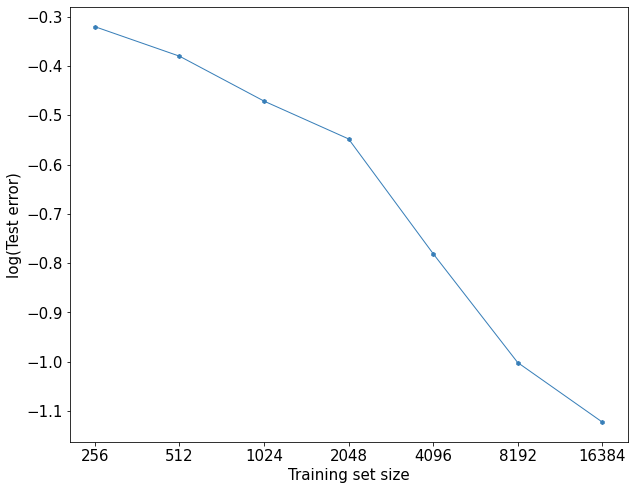

In [100]:
plot_figure("Training set size", "Test error", FLAGS["n_train_list"], 
            test_errors_list, xticks=FLAGS["n_train_list"], save_path=test_error_path)

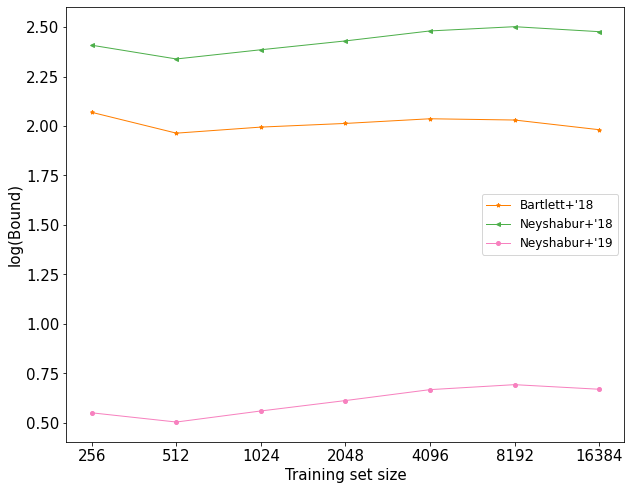

In [101]:
plot_figure("Training set size", "Bound", FLAGS["n_train_list"], bounds, xticks=FLAGS["n_train_list"], 
            save_path=test_bound_path,ylabels=["Bartlett+'18", "Neyshabur+'18", "Neyshabur+'19"])

In [89]:
import matplotlib.pyplot as plt

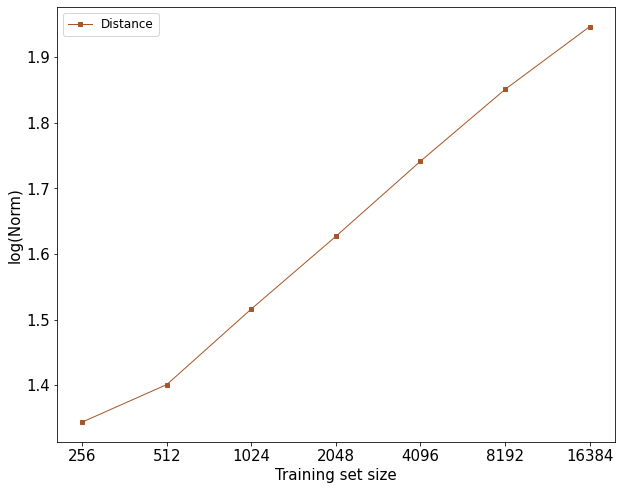

In [103]:
distances = [np.linalg.norm([np.linalg.norm(w[0] - w[1]) for w in zip(free_device(final_weights_list[k]), free_device(initial_weights))]) 
             for k in range(FLAGS["n_experiments"])]
plot_figure("Training set size", "Norm", FLAGS["n_train_list"],
            [distances],
            xticks=FLAGS["n_train_list"], 
            save_path=test_norm_path,
            ylabels=["Distance"])

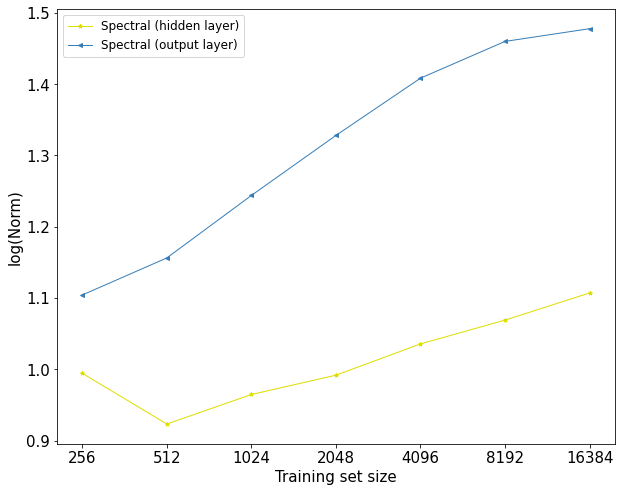

In [105]:
hidden_layer_spectral_norm = [np.linalg.norm(free_device(final_weights_list[k])[0], ord=2) for k in range(FLAGS["n_experiments"])]
output_layer_spectral_norm = [np.linalg.norm(free_device(final_weights_list[k])[2], ord=2) for k in range(FLAGS["n_experiments"])]
plot_figure("Training set size", "Norm", FLAGS["n_train_list"],
            [hidden_layer_spectral_norm, output_layer_spectral_norm],
            xticks=FLAGS["n_train_list"], 
            save_path=test_norm_path,
            ylabels=["Spectral (hidden layer)", "Spectral (output layer)"])

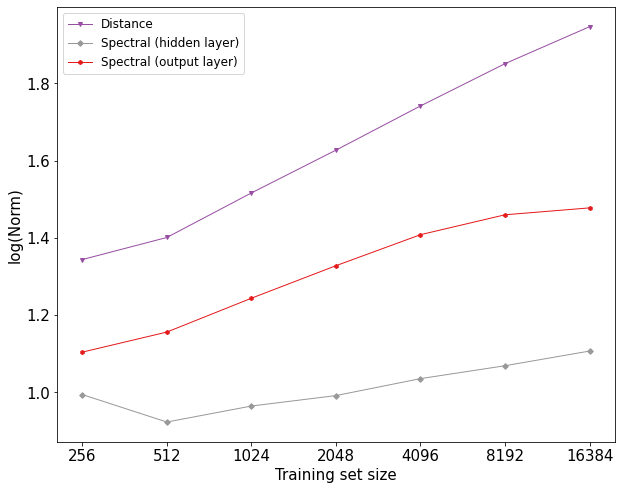

In [104]:
distances = [np.linalg.norm([np.linalg.norm(w[0] - w[1]) for w in zip(free_device(final_weights_list[k]), free_device(initial_weights))]) 
             for k in range(FLAGS["n_experiments"])]
hidden_layer_spectral_norm = [np.linalg.norm(free_device(final_weights_list[k])[0], ord=2) for k in range(FLAGS["n_experiments"])]
output_layer_spectral_norm = [np.linalg.norm(free_device(final_weights_list[k])[2], ord=2) for k in range(FLAGS["n_experiments"])]
plot_figure("Training set size", "Norm", FLAGS["n_train_list"],
            [distances, hidden_layer_spectral_norm, output_layer_spectral_norm],
            xticks=FLAGS["n_train_list"], 
            save_path=test_norm_path,
            ylabels=["Distance", "Spectral (hidden layer)", "Spectral (output layer)"])

# Part II: The provable failure of uniform convergence

In [69]:
# Hyperparams
FLAGS_2 = {
    "batch_size": 64, 
    "input_dim": 500,
    "n_classes" : 2,
    "width" : 10000,
    "depth" : 2,
    "learning_rate" : 0.2,
    "threshold" : 0.001, # Proportion of training points can we ignore
    "margin" : 8, # Margin that needs to be achieved on most of the training points
    "n_test" : 4096,
    "inner_radius" : 1.0,
    "outer_radius" : 1.2,
    "n_train_list" : [512, 1024,2048,4096,8192,16384], # To experiment with larger dataset sizes,
    "seed" : 5959
}

In [70]:
FLAGS_2['path'] = sub_dir_path

In [71]:
part2_test_projected_plot = FLAGS_2['path'] + 'test_projected_plot.png'
part2_hyper_sphere_plot1 = FLAGS_2['path'] + 'test_hyper_sphere_plot_tr.png'
part2_hyper_sphere_plot2 = FLAGS_2['path'] + 'test_hyper_sphere_plot_te.png'

In [72]:
# temporalily generate network for the fixed initialization of parameters
init_model_2 = Network(**FLAGS_2)
init_model_2 = init_model_2.to(device)
torch.cuda.manual_seed(FLAGS_2['seed'])
torch.manual_seed(FLAGS_2['seed'])
init_model_2 = init_model_2.apply(init_weights)
initial_weights_2 = list(init_model_2.parameters())
initial_dict_2 = init_model_2.state_dict()
del init_model_2
gc.collect()

479

In [73]:
# We sample a test set, and multiple independent draws of training sets of varying sizes
test_dataset2 = get_random_data(FLAGS_2["n_test"], FLAGS_2["input_dim"], FLAGS_2["inner_radius"], FLAGS_2["outer_radius"])

# Note that the function get_random_data is not visible in the blog, but can be found in the notebook after downloading
FLAGS_2["n_experiments"] = len(FLAGS_2["n_train_list"])
training_dataset_list2 = [[] for n_train in FLAGS_2["n_train_list"]]

for k in range(FLAGS_2["n_experiments"]):
    training_dataset_list2[k] = get_random_data(FLAGS_2["n_train_list"][k], FLAGS_2["input_dim"], FLAGS_2["inner_radius"], FLAGS_2["outer_radius"])

In [74]:
# We compute S' by projecting the training set
# on to the correspond opposite hyperspheres
projected_train_labels_list_2 =  [[] for n_train in FLAGS_2["n_train_list"]]
projected_train_inputs_list_2 = [[] for n_train in FLAGS_2["n_train_list"]]
for k in range(FLAGS_2["n_experiments"]):
    projected_train_labels_list_2[k] = 1-np.copy(training_dataset_list2[k].tensors[1]) # Flip labels
    projected_train_inputs_list_2[k] = np.copy(training_dataset_list2[k].tensors[0])
    for i in range(FLAGS_2["n_train_list"][k]):
        if projected_train_labels_list_2[k][i,0] == 1:
            projected_train_inputs_list_2[k][i,:] = projected_train_inputs_list_2[k][i,:]*FLAGS_2["inner_radius"]/FLAGS_2["outer_radius"]
        else:
            projected_train_inputs_list_2[k][i,:] =  projected_train_inputs_list_2[k][i,:]*FLAGS_2["outer_radius"]/FLAGS_2["inner_radius"]

projected_train_dataset_list2 = [TensorDataset(torch.tensor(X), torch.tensor(y)) for X, y in zip(projected_train_inputs_list_2, projected_train_labels_list_2)]

In [84]:
projected_train_errors_list_2 = [[] for k in range(FLAGS_2["n_experiments"])] # List of training errors on the projected training set across different experiments
final_weights_list_2 = [[] for k in range(FLAGS_2["n_experiments"])] # Weights learned for each dataset size
final_dicts_2 = [[] for k in range(FLAGS_2["n_experiments"])]
test_errors_list_2 = [0 for k in range(FLAGS_2["n_experiments"])] # Test error for each dataset size

for k in range(FLAGS_2["n_experiments"]):
    print(f"\n[INFO] Experiment no. {k + 1} running...")
    
    # Define model
    model_2 = Network(**FLAGS_2)
    model_2 = model_2.to(device)
    model_2.load_state_dict(initial_dict_2)
    
    # Define criterion and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model_2.parameters(), lr=FLAGS_2["learning_rate"])

    # Train
    print(f"[INFO] ...training!")
    epoch = 0
    train_margin_error = 1.0
    
    while train_margin_error > FLAGS_2["threshold"]:
        epoch += 1
        # Update weights, compute output on training data and then the margin-based training error 
        outs = perform_op_over_data(model_2, training_dataset_list2[k], criterion, optimizer, \
                                    device=device, batch_size=FLAGS_2['batch_size']) 
        train_margin_error = get_margin_error(model_2, training_dataset_list2[k], criterion, optimizer, \
                                              device=device, batch_size=FLAGS_2['batch_size'], mode=DATA_MODE)
        print(f"[INFO] [EXP{str(k + 1).zfill(2)}] Epoch {epoch:2d}\n[INFO] [EXP{str(k + 1).zfill(2)}] current margin error: {train_margin_error:.4f}")

        # Compute the error on the projected training set and test (just for monitoring)
        projected_train_error = get_margin_error(model_2, projected_train_dataset_list2[k], criterion, optimizer, \
                                                 device=device, batch_size=FLAGS_2['batch_size'], mode=DATA_MODE)  
        test_error = get_margin_error(model_2, test_dataset2, criterion, optimizer, device=device, \
                                      batch_size=FLAGS_2['batch_size'], mode=DATA_MODE)  
        print("Errors | Training: "+str(train_margin_error)+" Projected training: "+str(projected_train_error)+" Test:"+str(test_error))

    
    # Store the errors
    print(f"[INFO] ...test!\n")
    projected_train_errors_list_2[k] = projected_train_error 
    test_errors_list_2[k] = test_error
    final_weights_list_2[k] = list(model_2.parameters())
    final_dicts_2[k] = model_2.state_dict()
    
    torch.cuda.empty_cache()

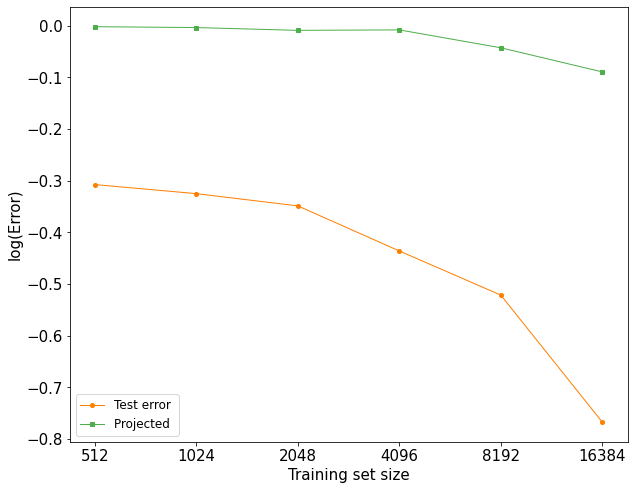

In [106]:
plot_figure("Training set size", "Error", FLAGS_2["n_train_list"], 
            [test_errors_list_2, projected_train_errors_list_2], save_path=part2_test_projected_plot,
            xticks=FLAGS_2["n_train_list"], ylabels=["Test error", "Projected "])

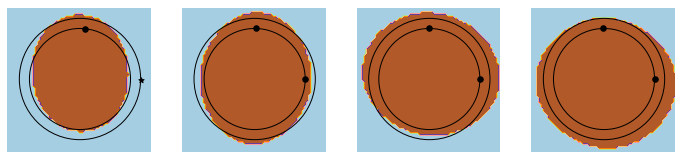

In [81]:
k=-1# Pick the experiment corresponding to the largest dataset
plot_slices(model_2, 4, training_dataset_list2[k].tensors[0], \
            training_dataset_list2[k].tensors[1], device=device,\
            save_path=part2_hyper_sphere_plot1, **FLAGS_2)

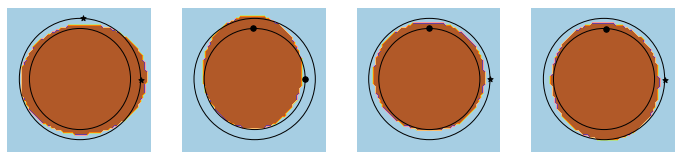

In [82]:
plot_slices(model_2, 4, test_dataset2.tensors[0], \
            test_dataset2.tensors[1], device=device,\
            save_path=part2_hyper_sphere_plot2, **FLAGS_2)